In [51]:
import pickle
import sys
import os

sys.path.append(sys.path[0] + "/..")  # Adds higher directory to python modules path.


import matplotlib.pyplot as plt
import numpy as np
import powerlaw as pwl
import scipy
from Functions import plotting, support
from scipy.stats import entropy as sp_entropy

plt.rcParams["text.usetex"] = True
colors = np.array(
    [ 
        [0.3647, 0.2824, 0.1059],
        [0.8549, 0.6314, 0.3294],
        [0.4745, 0.5843, 0.5373],
        [0.4745, 0.3843, 0.7373],
        [107.0 / 255, 42.0 / 255, 2.0 / 255],
    ]
)
SMALL_SIZE = 10
MEDIUM_SIZE = 12
BIGGER_SIZE = 13

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

In [52]:
d = 1
s = 1

path = f"../Tests/C_Elegans/"
with open(path + "/deg_dist_null.pkl", "rb") as f:
    deg_dist_null = pickle.load(f)
with open(path + "/deg_dist.pkl", "rb") as f:
    deg_dist = pickle.load(f)
with open(path + "/sp_dist_null.pkl", "rb") as f:
    sp_dist_null = pickle.load(f)
with open(path + "/sp_dist.pkl", "rb") as f:
    sp_dist = pickle.load(f)
dim = support.list_dim(deg_dist)
renorms = dim[2]
d = dim[3] 
n_tau = dim[1]
rep = dim[0]

In [53]:
def KS(deg1,deg2):
    test = scipy.stats.kstest(deg1, deg2)
    return test.statistic 

def mean_degree(deg1,deg2):
    return np.mean(deg2)


def JS(deg1,deg2):
    dmax = int(max(np.max(deg1),np.max(deg2)))
    p1 = np.zeros(dmax+1)
    p2 = np.zeros(dmax+1)
    for i in deg1:
        p1[int(i)] += 1
    for i in deg2:
        p2[int(i)] += 1
    p1 = p1/np.sum(p1)
    p2 = p2/np.sum(p2)
    p12 = 0.5 * (p1 + p2)
    jsd = 0.5 * (sp_entropy(p1, p12, base=2) + sp_entropy(p2, p12, base=2))
    return jsd

In [54]:
support.list_dim(deg_dist_null)

[1, 50, 1, 1]

In [55]:

measure = mean_degree

Ns = np.zeros((rep, renorms, n_tau), dtype=int)
Ns_null = np.zeros((rep, renorms, n_tau), dtype=int)

for r in range(rep):
    for i in range(renorms):
        for t in range(n_tau):
            Ns[r, i, t] = len(deg_dist[r][t][i][0])
            Ns_null[r, i, t] = len(deg_dist_null[r][t][i][0])

deg_distance = np.zeros((rep, d+1, d, n_tau))
deg_distance_null = np.zeros((rep, d+1, d, n_tau))

for r in range(rep):
    for norml in range(d):
        for degg in range(d):
            deg1 = deg_dist[r][0][norml][degg]
            deg1n = deg_dist_null[r][0][norml][degg]
            for tau in range(n_tau):
                deg2 = deg_dist[r][tau][norml][degg]
                deg2n = deg_dist_null[r][tau][norml][degg]
                if len(deg2) == 0:
                    deg2 = [0]
                if len(deg2n) == 0:
                    deg2n = [0]
                deg_distance[r, norml, degg, tau] = measure(deg1,deg2)
                deg_distance_null[r, norml, degg, tau] = measure(deg1,deg2)

N = Ns[0,0,0]


IndexError: index 1 is out of bounds for axis 1 with size 1

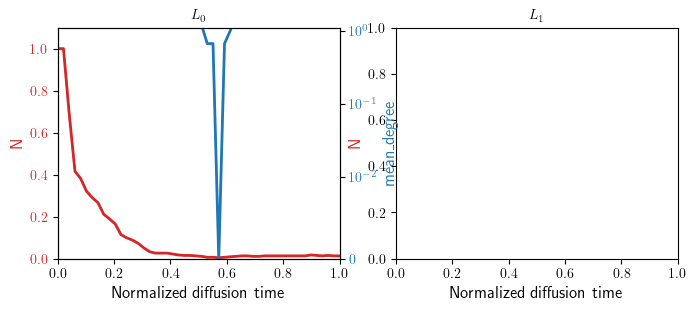

In [44]:
fig, axv = plt.subplots(d,d+1,figsize = (4*(d+1),3*d))

for degg in range(d):
    for norml in range(d+1):
        color = 'tab:red'
        if d == 1:
            ax1 = axv[norml]
        else:
            ax1 = axv[degg,norml]
        ax1.set_title("$L_"+str(norml)+"$")
        ax1.set_xlabel('Normalized diffusion time')
        ax1.set_ylabel('N', color=color)
        for r in range(rep):
            ax1.plot(np.linspace(0,1,n_tau), Ns[r,norml,:]/N, color=color, alpha = 0.3)

        ax1.plot(np.linspace(0,1,n_tau), np.median(Ns[:,norml,:]/N,0), color = color, lw = 2)

        ax1.tick_params(axis='y', labelcolor=color)
        ax1.set_xlim(0,1)
        ax1.set_ylim(bottom = 0, top = 1.1)

        ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

        color = 'tab:blue'
        ax2.set_ylabel(measure.__name__, color=color)  # we already handled the x-label with ax1
        for r in range(rep):
            ax2.plot(np.linspace(0,1,n_tau), deg_distance[r,norml,degg,:], color=color, alpha = 0.2)
        ax2.plot(np.linspace(0,1,n_tau), np.median(deg_distance[:,norml,degg,:],0), color = color, lw = 2)

        ax2.tick_params(axis='y', labelcolor=color)
        ax2.set_yscale('symlog',linthresh=0.01)
        ax2.set_ylim(bottom = 0, top = 1.1)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig(path + f"/deg_errors_{measure.__name__}.pdf", format="pdf")  # , bbox_inches="tight")


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


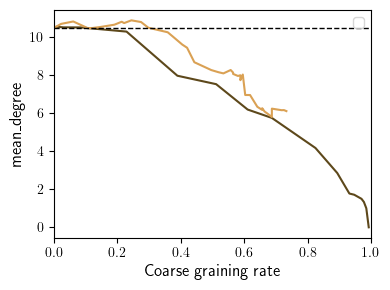

In [8]:
fig, axv = plt.subplots(1,d,figsize = (4*d,3))

for degg in range(d):
    if d == 1:
        ax1 = axv
    else:
        ax1 = axv[degg]
    #ax1.set_title("$L_"+str(norml)+"$")
    ax1.set_xlabel('Coarse graining rate')
    ax1.set_ylabel(measure.__name__)
    #ax1.set_ylim(bottom = 0, top = 1)
    ax1.set_xlim(0,1)
    #ax1.set_yscale('symlog',linthresh=0.01)
    for norml in range(d+1):
        for r in range(rep):
                id = np.argsort(1-Ns[r,norml,:]/N)
                ax1.plot(1-Ns[r,norml,id]/N, deg_distance[r,norml,degg,id], color=colors[norml,:], alpha = 1)
        #ax1.plot(1-np.median(Ns[:,norml,:]/N,0), np.median(deg_distance[:,norml,degg,:],0), color = colors[norml,:], lw = 2,label = f"$L_{norml}$")
    ax1.legend()
    if measure.__name__ in ["mean_degree", "degree_variance", "density"] :
            ax1.hlines(deg_distance[:,0,degg,0], 0, 1, colors='black', lw = 1, linestyles='--')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig(path + f"/coarse_graining_rate_together_{measure.__name__}.pdf", format="pdf")  # , bbox_inches="tight")

In [145]:
deg_dist[0][tau_simp0][0][0]

array([131.,  19.,  25.,  17.,   1.,   1.,   9.,  56.,   1.,   4.,   9.,
        13.,   9.,   9.,   2.,  15.,  11.,   3.,   2.,   0.,   0.,   2.,
        19.,  23.,  16.,  11.,  15.,  19.,   2.,  10.,  15.,   5.,  13.,
         6.,   7.,  14.,  10.,   5.,   5.,   5.,  17.,  11.,  12.,   7.,
        10.,   0.,   8.,  14.,  18.,  21.,  14.,  17.,  10.,   1.,   3.,
         0.,   2.,   2.,   0.,   0.,   0.,   0.,   1.,   3.,   1.,   6.,
         8.,   3.,   4.,   4.,   3.,   3.,   4.,   6.,   5.,   9.,   9.,
         7.,   5.,   8.])

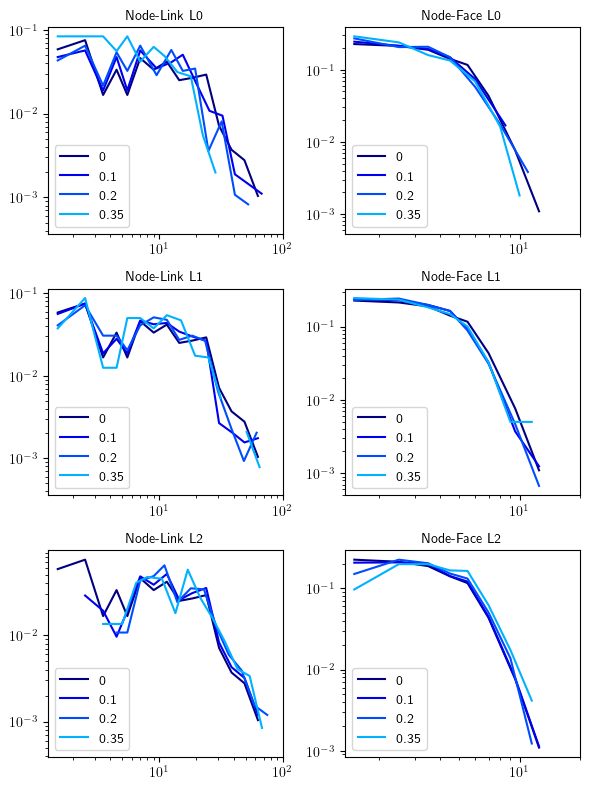

In [156]:

fig, axs  = plt.subplots(3,2,figsize = (6,8))
thr = [0,0.1,0.2,0.35]
norml = 2

tau_simp0 = [0,0,0,0]
tau_simp1 = [0,0,0,0]
tau_simp2 = [0,0,0,0]

for t in range(len(thr)):
    tau_simp0[t] = np.argwhere(1-Ns[0,0,:]/N>=thr[t])[0,0]
    tau_simp1[t] = np.argwhere(1-Ns[0,1,:]/N>=thr[t])[0,0]
    tau_simp2[t] = np.argwhere(1-Ns[0,2,:]/N>=thr[t])[0,0]

new_colors = [plt.get_cmap('jet')(1. * i/10) for i in range(10)]
plt.rc('axes', prop_cycle=(cycler('color', new_colors)))

for tau in range(len(thr)):
    pwl.plot_pdf(deg_dist[0][tau_simp0[tau]][0][0][deg_dist[0][tau_simp0[tau]][0][0] != 0], ax = axs[0,0])
    axs[0,0].set_title("Node-Link L0")
    axs[0,0].set_xlim(xmax = 100)
axs[0,0].legend(thr)
for tau in range(len(thr)):
    pwl.plot_pdf(deg_dist[0][tau_simp0[tau]][0][1][deg_dist[0][tau_simp0[tau]][0][1] != 0], ax = axs[0,1])
    axs[0,1].set_title("Node-Face L0")
    axs[0,1].set_xlim(xmax = 20)
axs[0,1].legend(thr)


for tau in range(len(thr)):
    pwl.plot_pdf(deg_dist[0][tau_simp1[tau]][1][0][deg_dist[0][tau_simp1[tau]][1][0] != 0], ax = axs[1,0])
    axs[1,0].set_title("Node-Link L1")
    axs[1,0].set_xlim(xmax = 100)
axs[1,0].legend(thr)
for tau in range(len(thr)):
    pwl.plot_pdf(deg_dist[0][tau_simp1[tau]][1][1][deg_dist[0][tau_simp1[tau]][1][1] != 0], ax = axs[1,1])
    axs[1,1].set_title("Node-Face L1")
    axs[1,1].set_xlim(xmax = 20)
axs[1,1].legend(thr)


for tau in range(len(thr)):
    pwl.plot_pdf(deg_dist[0][tau_simp2[tau]][2][0][deg_dist[0][tau_simp2[tau]][2][0] != 0], ax = axs[2,0])
    axs[2,0].set_title("Node-Link L2")
    axs[2,0].set_xlim(xmax = 100)
axs[2,0].legend(thr)

for tau in range(len(thr)):
    pwl.plot_pdf(deg_dist[0][tau_simp2[tau]][2][1][deg_dist[0][tau_simp2[tau]][2][1] != 0], ax = axs[2,1])
    axs[2,1].set_title("Node-Face L2")
    axs[2,1].set_xlim(xmax = 20)
axs[2,1].legend(thr)

plt.tight_layout()
plt.savefig(path + f"/deg_distributions_L{norml}.pdf", format="pdf")  # , bbox_inches="tight")

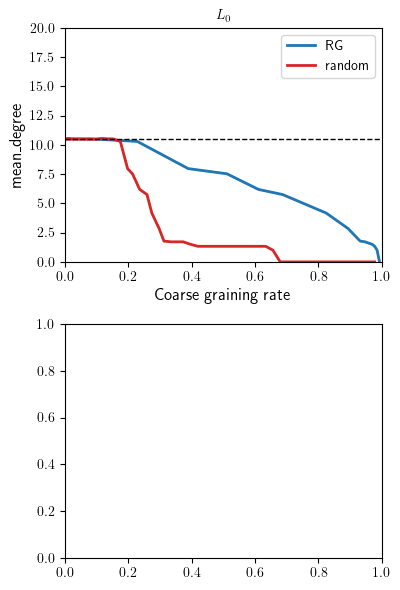

In [24]:

topp = [20,12]
logg = False
fig, axv = plt.subplots(d+1,d,figsize = (4*d,3*(d+1)))

for norml in range(d+1-1):
    for degg in range(d):
        if d == 1:
            ax1 = axv[norml]
        else:
            ax1 = axv[norml,degg]
        #ax1.set_title("$L_"+str(norml)+"$")
        ax1.set_xlabel('Coarse graining rate')
        ax1.set_ylabel(measure.__name__)
        ax1.set_ylim(bottom = 0 ,top = topp[degg])
        ax1.set_xlim(0,1)
        if logg:
            #ax1.set_yscale('log')
            ax1.set_yscale('symlog',linthresh=0.000001)
        for r in range(rep):
                ax1.plot(1-Ns[r,norml,:]/N, deg_distance[r,norml,degg,:], color="tab:blue", alpha = 0.2)
        ax1.plot(1-np.median(Ns[:,norml,:]/N,0), np.median(deg_distance[:,norml,degg,:],0), color = "tab:blue", lw = 2, label = "RG")
        for r in range(rep):
                ax1.plot(1-Ns_null[r,norml,:]/N, deg_distance_null[r,norml,degg,:], color="tab:red", alpha = 0.2)
        ax1.plot(1-np.median(Ns_null[:,norml,:]/N,0), np.median(deg_distance_null[:,norml,degg,:],0), color = "tab:red", lw = 2, label = "random")
        ax1.legend()
        ax1.set_title(f"$L_{norml}$")
        if measure.__name__ in ["mean_degree", "degree_variance", "density","energy_degree"] :
            ax1.hlines((np.median(deg_distance_null[:,norml,degg,0])+np.median(deg_distance[:,norml,degg,0]))/2, 0, 1, colors='black', lw = 1, linestyles='--')
fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.savefig(path + f"/ER{d}_{measure.__name__}.pdf", format="pdf")  # , bbox_inches="tight")

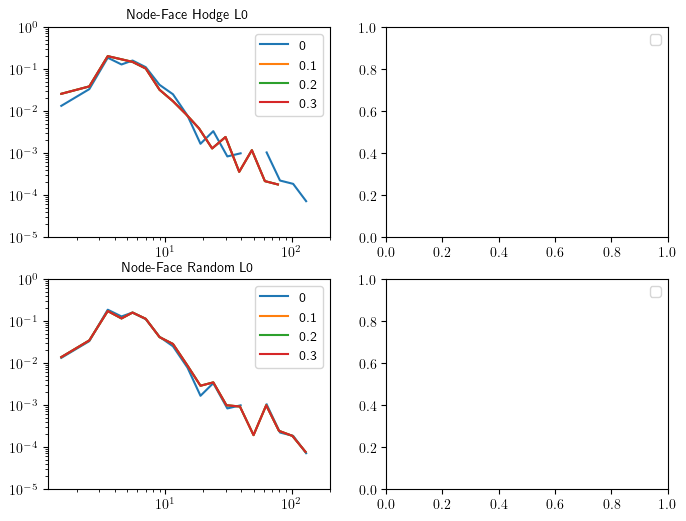

In [8]:
fig, axs  = plt.subplots(2,2,figsize = (8,6))

thr = [0,0.1,0.2,0.3]
norml = 0

r = 0
tau_simp0 = [0,0,0,0]
tau_simp1 = [0,0,0,0]

for t in range(len(thr)):
    tau_simp0[t] = np.argwhere(np.abs(1-Ns[r,norml,:]/N)>=thr[t])[0,0]
    tau_simp1[t] = np.argwhere(np.abs(1-Ns[r,norml,:]/N)>=thr[t])[0,0]


#new_colors = [plt.get_cmap('jet')(1. * i/10) for i in range(10)]
#plt.rc('axes', prop_cycle=(cycler('color', new_colors)))

for tau in range(len(thr)):
    pwl.plot_pdf(deg_dist[r][tau_simp0[tau]][norml][0][deg_dist[r][tau_simp0[tau]][norml][0] != 0], ax = axs[0,0])
    axs[0,0].set_title(f"Node-Face Hodge L{norml}")
    axs[0,0].set_xlim(xmax = 200)
    axs[0,0].set_ylim(ymax = 1, ymin = 10**-5)
# for tau in range(len(thr)):
#     pwl.plot_pdf(deg_dist_simple[r][tau_simp0[tau]][norml][1][deg_dist_simple[r][tau_simp0[tau]][norml][1] != 0], ax = axs[0,1])
#     axs[0,1].set_title(f"Link-Face Hodge L{norml}")
#     axs[0,1].set_xlim(xmax = 40)
#     axs[0,1].set_ylim(ymax = 1, ymin = 10**-5)

for tau in range(len(thr)):
    pwl.plot_pdf(deg_dist_null[r][tau_simp1[tau]][norml][0][deg_dist_null[r][tau_simp1[tau]][norml][0] != 0], ax = axs[1,0])
    axs[1,0].set_title(f"Node-Face Random L{norml}")
    axs[1,0].set_xlim(xmax = 200)
    axs[1,0].set_ylim(ymax = 1, ymin = 10**-5)

# for tau in range(len(thr)):
#     pwl.plot_pdf(deg_dist_random[r][norml][tau_simp1[tau]][1][deg_dist_random[r][norml][tau_simp1[tau]][1] != 0], ax = axs[1,1])
#     axs[1,1].set_title(f"Link-Face Random L{norml}")
#     axs[1,1].set_xlim(xmax = 40)
#     axs[1,1].set_ylim(ymax = 1, ymin = 10**-5)

for i in range(2):
    for j in range(2):
        axs[i,j].legend(thr)
plt.savefig("../Tests/Comparison_null_model" + f"/{d}_deg_distributions_L{norml}ER.pdf", format="pdf")  # , bbox_inches="tight")

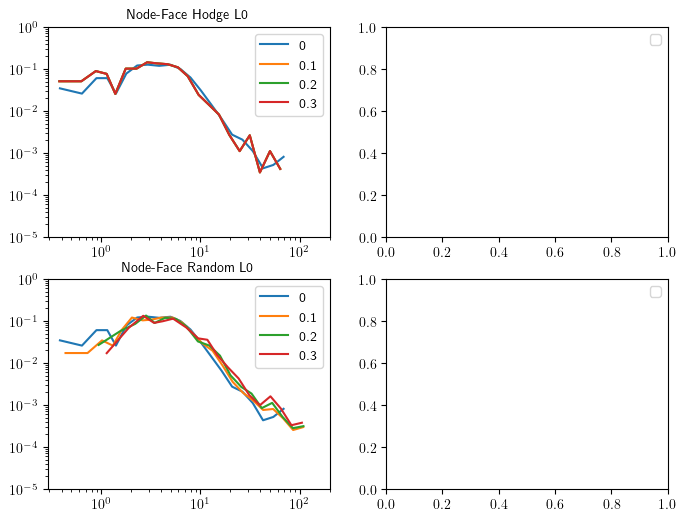

In [56]:
fig, axs  = plt.subplots(2,2,figsize = (8,6))

thr = [0,0.1,0.2,0.3]
norml = 0

r = 0
tau_simp0 = [0,0,0,0]
tau_simp1 = [0,0,0,0]

for t in range(len(thr)):
    tau_simp0[t] = np.argwhere(np.abs(1-Ns[r,norml,:]/N)>=thr[t])[0,0]
    tau_simp1[t] = np.argwhere(np.abs(1-Ns_null[r,norml,:]/N)>=thr[t])[0,0]


#new_colors = [plt.get_cmap('jet')(1. * i/10) for i in range(10)]
#plt.rc('axes', prop_cycle=(cycler('color', new_colors)))

for tau in range(len(thr)):
    pwl.plot_pdf(sp_dist[r][tau_simp0[tau]][norml][0][0][sp_dist[r][tau_simp0[tau]][norml][0][0] > 0], ax = axs[0,0])
    axs[0,0].set_title(f"Node-Face Hodge L{norml}")
    axs[0,0].set_xlim(xmax = 200)
    axs[0,0].set_ylim(ymax = 1, ymin = 10**-5)
# for tau in range(len(thr)):
#     pwl.plot_pdf(deg_dist_simple[r][tau_simp0[tau]][norml][1][deg_dist_simple[r][tau_simp0[tau]][norml][1] != 0], ax = axs[0,1])
#     axs[0,1].set_title(f"Link-Face Hodge L{norml}")
#     axs[0,1].set_xlim(xmax = 40)
#     axs[0,1].set_ylim(ymax = 1, ymin = 10**-5)

for tau in range(len(thr)):
    pwl.plot_pdf(sp_dist_null[r][tau_simp1[tau]][norml][0][0][sp_dist_null[r][tau_simp1[tau]][norml][0][0] > 0], ax = axs[1,0])
    axs[1,0].set_title(f"Node-Face Random L{norml}")
    axs[1,0].set_xlim(xmax = 200)
    axs[1,0].set_ylim(ymax = 1, ymin = 10**-5)

# for tau in range(len(thr)):
#     pwl.plot_pdf(deg_dist_random[r][norml][tau_simp1[tau]][1][deg_dist_random[r][norml][tau_simp1[tau]][1] != 0], ax = axs[1,1])
#     axs[1,1].set_title(f"Link-Face Random L{norml}")
#     axs[1,1].set_xlim(xmax = 40)
#     axs[1,1].set_ylim(ymax = 1, ymin = 10**-5)

for i in range(2):
    for j in range(2):
        axs[i,j].legend(thr)
plt.savefig("../Tests/Comparison_null_model" + f"/{d}_deg_distributions_L{norml}ER.pdf", format="pdf")  # , bbox_inches="tight")

In [30]:
tau_simp1[tau]

2

<AxesSubplot: >

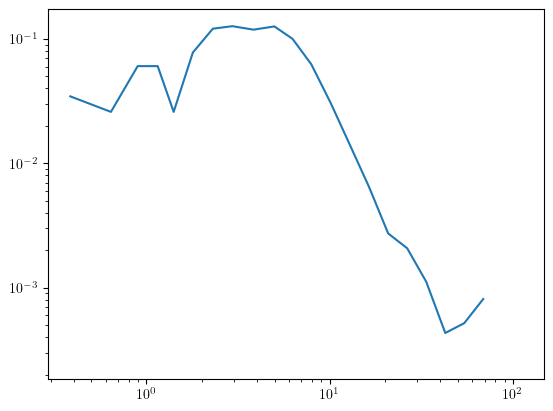

In [34]:
pwl.plot_pdf(sp_dist_null[0][5][0][0][0][sp_dist_null[r][5][0][0][0] > 0])
